# DL-модель для классификации состояния дерева (Good/Fair/Poor) по данным из NY 2015 Street Tree Census.

## Импорт библиотек

In [1]:
import os
import zipfile
import requests
import pandas as pd
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder


## Dowload dataset 2015 Street Tree Census - Tree Data

Описание датасета https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh/about_data

In [2]:
# Путь к директории с исходными данными 
path_raw = os.path.expanduser("../data/raw")
# URL для загрузки датасета
url = "https://www.kaggle.com/api/v1/datasets/download/new-york-city/ny-2015-street-tree-census-tree-data"

name_dataset = "2015-street-tree-census-tree-data" 
output_path = os.path.expanduser(f"{path_raw}/{name_dataset}.zip")


In [3]:
def download_file(url, output_path):
    """ 
    Загрузка файла по URL и сохранение в output_path
    """
    # Проверка наличия архива
    if not os.path.exists(output_path):
        # Загрузка файла
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(output_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=128):
                    f.write(chunk)
            print(f"Файл загружен: {output_path}")
        else:
            print(f"Ошибка при загрузке файла: {response.status_code}")
    else:
        print(f"Файл уже существует: {output_path}")

    # Распаковка архива
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall(path_raw)
        print("Файлы распакованы")

download_file(url, output_path)

Файл уже существует: ../data/raw/2015-street-tree-census-tree-data.zip


Файлы распакованы


In [4]:
df = pd.read_csv(f'{path_raw}/{name_dataset}.csv')
df.head(3)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,2015-08-27T00:00:00.000,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,2015-09-03T00:00:00.000,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,2015-09-05T00:00:00.000,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09


## Анализ данных

In [5]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.columns

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community_board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council_district',
       'census_tract', 'bin', 'bbl'],
      dtype='object')

In [6]:
# Распределение таргета
print(df[['status', 'health']].value_counts())
print(df[df['status'] != 'Alive']['status'].value_counts())
print(df[df['status'] != 'Alive']['health'].value_counts())
# Только у живых деревьев есть health status
df = df[df['status'] == 'Alive']
# Удалим строки с пропущенными значениями в health - это наш таргет
df.dropna(subset=['health'], inplace=True)  

df.shape

status  health
Alive   Good      528850
        Fair       96504
        Poor       26818
Name: count, dtype: int64
status
Stump    17654
Dead     13961
Name: count, dtype: int64
Series([], Name: count, dtype: int64)


(652172, 45)

In [7]:
# По описанию датасета, в нем содержится информация о деревьях в Нью-Йорке
# Найдем количество деревьев в каждом районе
df.borough.value_counts()

borough
Queens           237974
Brooklyn         169744
Staten Island    101442
Bronx             80585
Manhattan         62427
Name: count, dtype: int64

In [8]:
df.steward.value_counts().sort_values(ascending=False).head(10)

steward
1or2       143557
3or4        19183
4orMore      1610
Name: count, dtype: int64

In [9]:
df.state.value_counts().sort_values(ascending=False).head(10)

state
New York    652172
Name: count, dtype: int64

In [10]:
df.stump_diam.value_counts().sort_values(ascending=False).head(10)

stump_diam
0    652172
Name: count, dtype: int64

In [11]:
df.nta_name.value_counts().sort_values(ascending=False).head(10)

nta_name
Annadale-Huguenot-Prince's Bay-Eltingville        12530
Great Kills                                       10267
Bayside-Bayside Hills                              9386
East New York                                      9188
Rossville-Woodrow                                  8842
New Springville-Bloomfield-Travis                  8142
Charleston-Richmond Valley-Tottenville             7913
Forest Hills                                       7330
Whitestone                                         7253
Georgetown-Marine Park-Bergen Beach-Mill Basin     7221
Name: count, dtype: int64

In [12]:
print(
    "Максимальное количество уникальных названий вида дерева",
    "на латыне для каждого обывательского названия:",
    df.groupby("spc_common").spc_latin.nunique().max(),
)

print(
    "Максимальное количество уникальных обывательских названий",
    "вида дерева для каждого названия на латыне:",
    df.groupby("spc_latin").spc_common.nunique().max(),
)

Максимальное количество уникальных названий вида дерева на латыне для каждого обывательского названия: 1
Максимальное количество уникальных обывательских названий вида дерева для каждого названия на латыне: 1


In [13]:
def plot_corr_matrix(df, method='pearson', threshold=0.3, figsize=(20, 20)):
    """
    Построение матрицы корреляции с фильтрацией значимых корреляций.
    Исключает столбцы, которые не имеют значимых корреляций.
    """
    # Оставляем только числовые столбцы
    numeric_df = df.select_dtypes(include=[np.number, bool])
    
    if numeric_df.empty:
        print("Нет числовых данных для корреляции.")
        return
    
    # Удаляем столбцы с низкой вариативностью
    low_var_cols = [col for col in numeric_df.columns if numeric_df[col].nunique() <= 1]
    if low_var_cols:
        print(f"Удаляем столбцы с низкой вариативностью: {low_var_cols}")
        numeric_df.drop(columns=low_var_cols, inplace=True)
    
    if numeric_df.empty:
        print("После фильтрации нет данных для корреляции.")
        return
    
    # Вычисляем корреляционную матрицу
    corr = numeric_df.corr(method=method)
        
    # Обнуляем корреляции ниже порога
    corr[corr.abs() < threshold] = np.nan

    # Убираем строки и столбцы без значимой корреляции
    corr.dropna(how='all', axis=0, inplace=True)
    corr.dropna(how='all', axis=1, inplace=True)

    if corr.empty:
        print("Нет значимых корреляций по выбранному методу.")
        return
    
    # Построение тепловой карты
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
    plt.title(f'Корреляционная матрица ({method})')
    plt.show()



In [14]:
df.columns

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community_board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council_district',
       'census_tract', 'bin', 'bbl'],
      dtype='object')

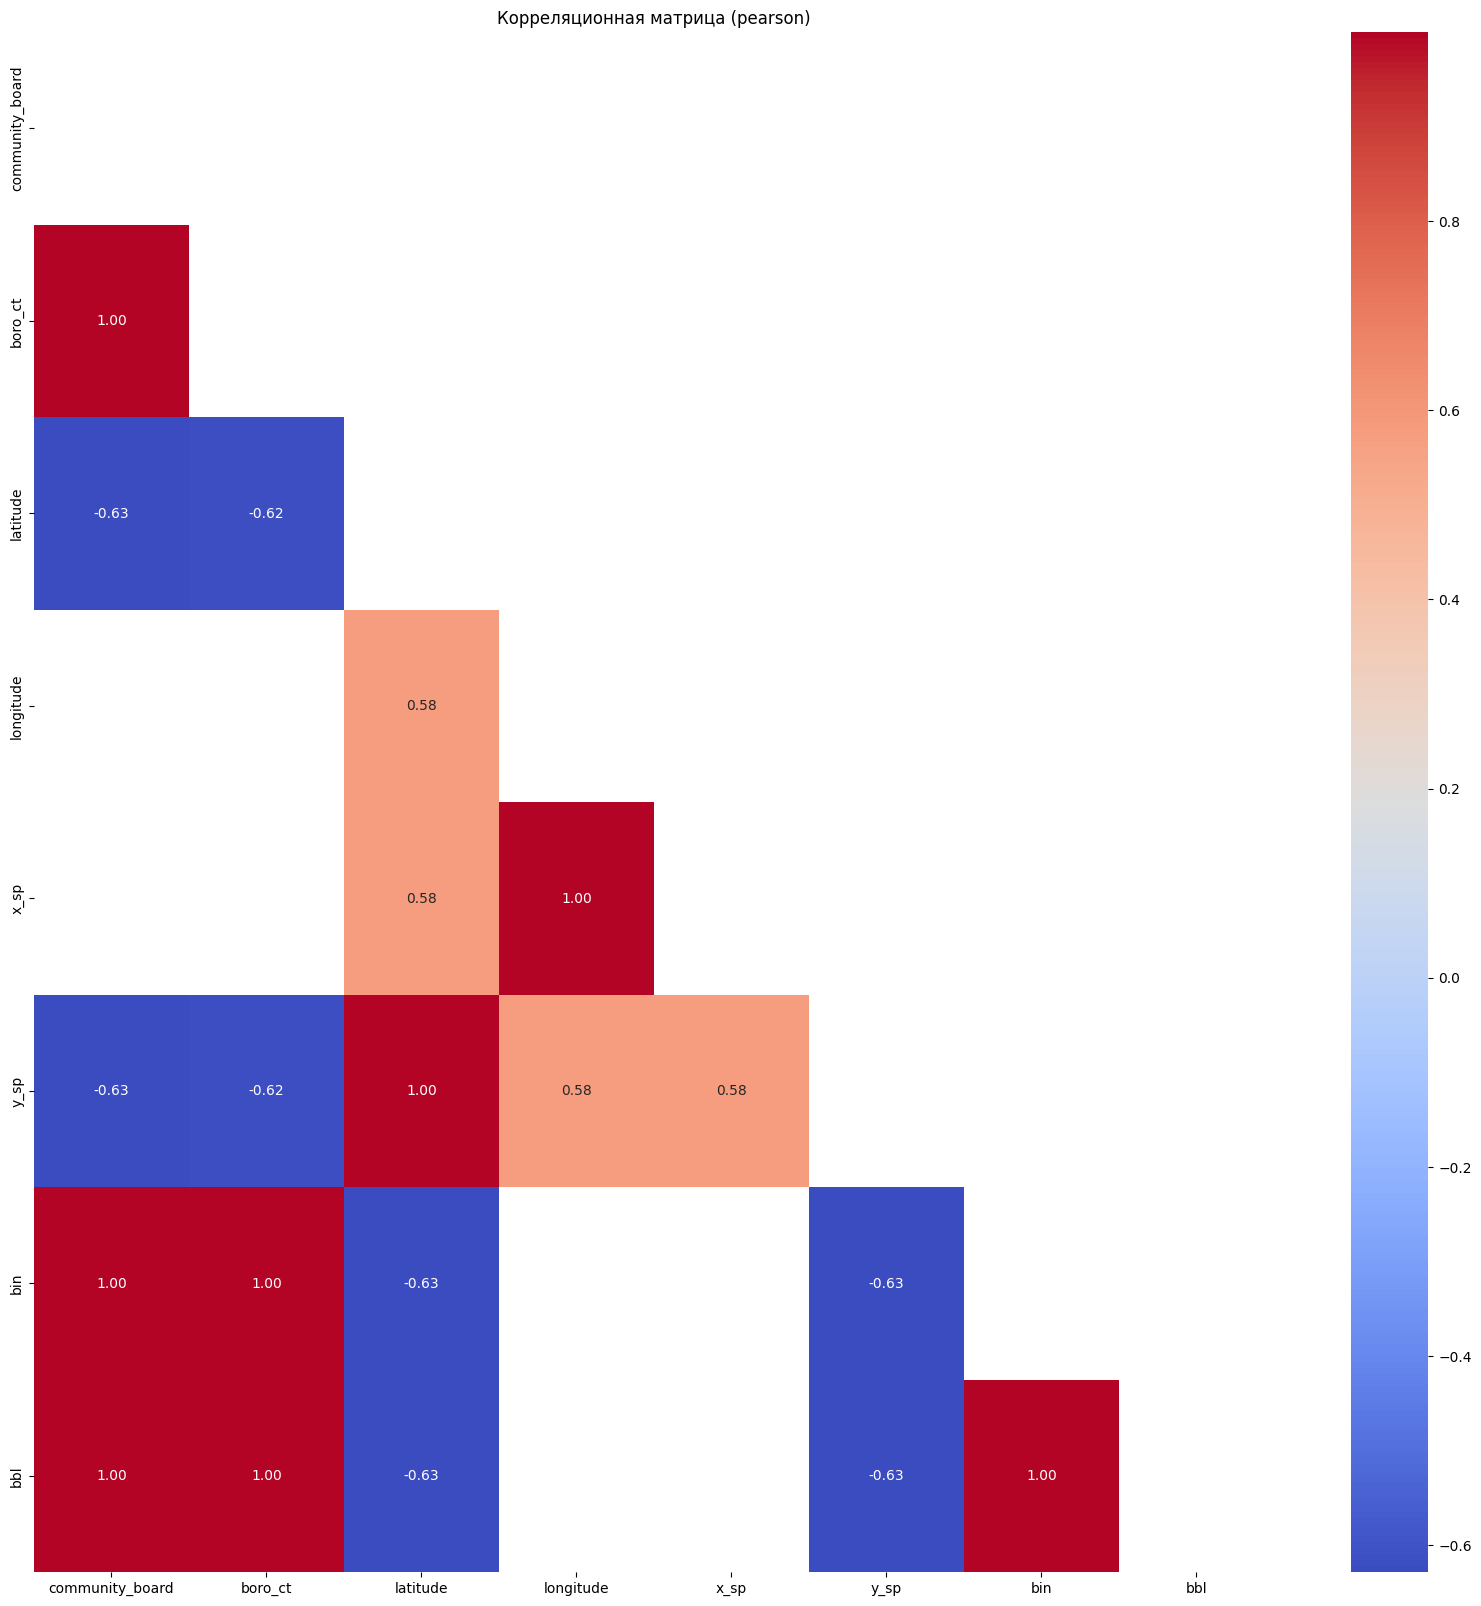

In [15]:
plot_corr_matrix(
    df[
        [
            "community_board",
            "boro_ct",
            "latitude",
            "longitude",
            "x_sp",
            "y_sp",
            "bin",
            "bbl",
        ]
    ],
    method="pearson",
)

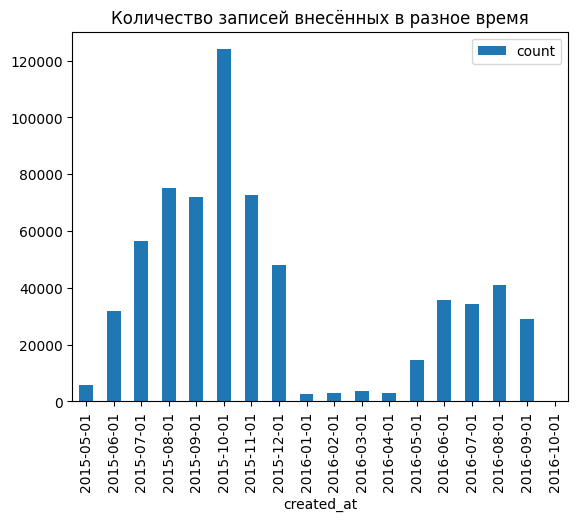

In [16]:
df.assign(created_at=lambda row: pd.to_datetime(row.created_at)) \
    .loc[:, ["created_at", "tree_id"]] \
    .resample("MS", on="created_at") \
    .count() \
    .rename(columns={"tree_id": "count"}) \
    .reset_index() \
    .assign(created_at=lambda row: row.created_at.dt.date) \
    .plot(
        kind="bar",
        x="created_at",
        y="count",
        title="Количество записей внесённых в разное время",
    ).get_figure().show()

plt.show()

Для задачи классификации состояния дерева (Good/Fair/Poor) некоторые столбцы могут быть не нужны,   
так как они не влияют на состояние дерева или являются избыточными.   
 Вот список столбцов, которые можно исключить:  
 -  status - все деревья живые, так как только у них есть значения healt(target) у мертвых и пенков нет
 -  state - все значения одинаковые ("New York")
 -  tree_id - уникальный идентификатор дерева
 -  created_at - дата создания записи. В течении года были записи
 -  stump_diam - диаметр пня. Все деревья живые, поэтому пень не имеет значения для состояния дерева и он везде ноль.
 -  borocode: Код района, не влияет на состояние. есть отдельный столбец borough
 -  x_sp: Координата X, коррелирует с longitude
 -  y_sp: Координата Y, коррелирует с latitude
 -  nta_name: есть отдельный столбец nta 
 -  council_district: район совета, не влияет на состояние
 -  census_tract: номер участка, не влияет на состояние
 -  nta_name - район, не влияет на состояние
 -  zip_city - код города
 -  spc_common - обывательское название. убираем т.к. везде есть латинское название
 -  community_board, bbl, bin - коррецирует с boro_ct



In [17]:
df_drop_columns = ['status', 'state', 'tree_id', 'created_at', 'stump_diam', 'address', 'spc_common',
                   'borocode', 'x_sp', 'y_sp', 'council_district', 'census_tract', 'nta_name',
                   'bin', 'zip_city', 'community_board', 'bbl']
df = df.drop(columns=df_drop_columns)
df.shape


(652172, 28)

In [18]:
df.isna().sum().sort_values(ascending=False).head(10)

guards       572306
steward      487822
problems     426328
spc_latin         5
sidewalk          1
curb_loc          0
tree_dbh          0
block_id          0
health            0
user_type         0
dtype: int64

array([[<Axes: title={'center': 'block_id'}>,
        <Axes: title={'center': 'tree_dbh'}>,
        <Axes: title={'center': 'postcode'}>],
       [<Axes: title={'center': 'cncldist'}>,
        <Axes: title={'center': 'st_assem'}>,
        <Axes: title={'center': 'st_senate'}>],
       [<Axes: title={'center': 'boro_ct'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>]], dtype=object)

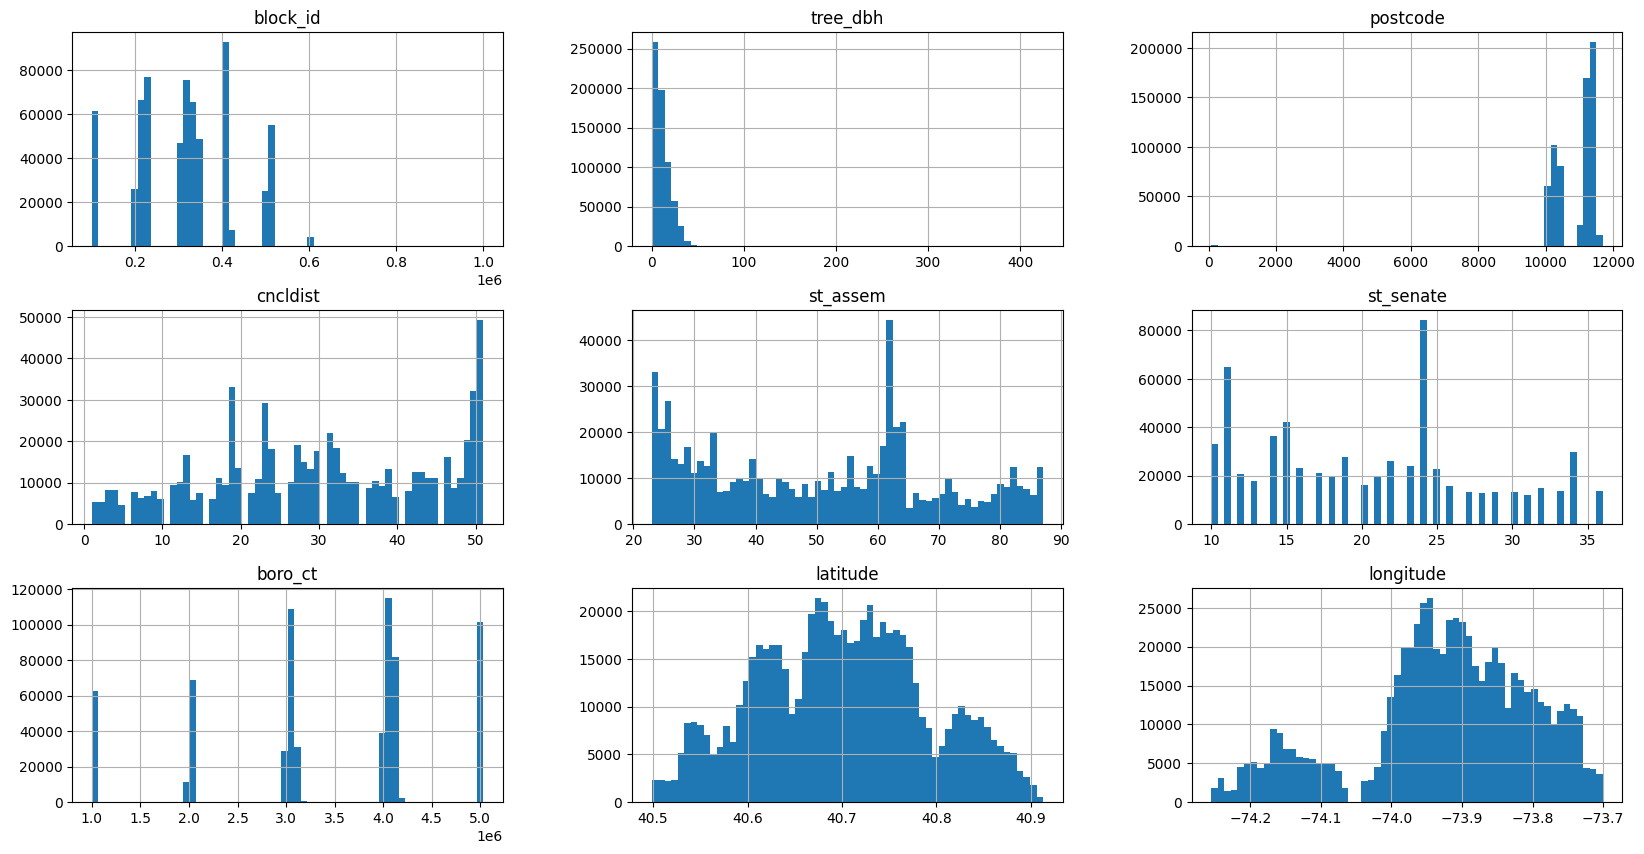

In [19]:
df.hist(bins=60, figsize=(20,10))


## Преоброзование данных

In [21]:
def df_fillna(df):
    df['spc_latin'].fillna('No observation',inplace=True)
    df['sidewalk'].fillna('NoDamage',inplace=True)
    df['problems'].fillna('NoProblem',inplace=True)
    df['steward'].fillna('None',inplace=True)
    df['guards'].fillna('Unsure',inplace=True)
    return df
df = df_fillna(df)
df.isna().sum().sort_values(ascending=False).head(10)



block_id     0
tree_dbh     0
curb_loc     0
health       0
spc_latin    0
steward      0
guards       0
sidewalk     0
user_type    0
problems     0
dtype: int64

In [22]:
def split_problems(df):
    """
    Функция для разделения строки с проблемами на отдельные проблемы,
    создания новых колонок для каждой проблемы и подсчета количества проблем.
    """
    
    # Разделение строки с проблемами на отдельные проблемы
    df['problems_new'] = df['problems'].str.split(',')
    
    # Получение уникальных проблем
    unique_problems = set(problem.strip().lower().replace(' ', '_') for sublist in df['problems_new'] for problem in sublist)
    print(unique_problems)
    
    # Создание новых колонок
    for problem in unique_problems:
        df[problem] = df['problems'].str.contains(problem, case=False)
    
    # Подсчет количества проблем
    df['num_problems'] = df['problems_new'].apply(len)
    
    df.drop(columns=['problems', 'problems_new'], inplace=True)

    return df

# Применение функции к вашему датасету
df = split_problems(df)

# Вывод первых строк для проверки
df[['trunklights', 'metalgrates', 'branchother', 'sneakers', 'wiresrope', 
    'branchlights', 'noproblem', 'rootother', 'stones', 'trunkother', 'num_problems']].head()

{'branchlights', 'trunkother', 'metalgrates', 'branchother', 'sneakers', 'wiresrope', 'trunklights', 'stones', 'noproblem', 'rootother'}


,trunklights,metalgrates,branchother,sneakers,wiresrope,branchlights,noproblem,rootother,stones,trunkother,num_problems
0,False,False,False,False,False,False,True,False,False,False,1
1,False,False,False,False,False,False,False,False,True,False,1
2,False,False,False,False,False,False,True,False,False,False,1
3,False,False,False,False,False,False,False,False,True,False,1
4,False,False,False,False,False,False,False,False,True,False,1


В колонке problems содержится информация о проблемах с деревьями
Разделили их на отдельные колонки
{'trunklights', 'metalgrates', 'branchother', 'sneakers', 'wiresrope', 'branchlights', 'noproblem', 'rootother', 'stones', 'trunkother'}
Это все уникальные проблемы для каждой мы создали колонку с будевым значением

In [23]:
def convert_to_bool(df):
    """
    Преобразование значений в столбцах в булевые значения
    curb_loc - OnCurb -> True, OffCurb -> False
    sidewalk - Damage -> True, NoDamage -> False
    root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other
    Yes -> True, No -> False
    """   
    df['curb_loc'] = df['curb_loc'].apply(lambda x: True if x == 'OnCurb' else False)

    df['sidewalk'] = df['sidewalk'].apply(lambda x: True if x == 'Damage' else False)

    # Преобразование других столбцов в булевые значения
    columns_to_convert = [
        'root_stone', 'root_grate', 'root_other', 'trunk_wire', 
        'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other'
    ]

    for col in columns_to_convert:
        df[col] = df[col].apply(lambda x: True if x == 'Yes' else False)
    return df
df = convert_to_bool(df)




In [24]:
new_columns =  [
            "wiresrope",
            "trunk_wire",
            "metalgrates",
            "root_grate",
            "root_stone",
            "stones",
            "trunklights",
            "trnk_light",
            "brch_light",
            "branchlights",
            "brch_other",
            "branchother",
            "brch_shoe",
            "sneakers",
            "root_other",
            "rootother",
            "trnk_other",
            "trunkother",
        ]

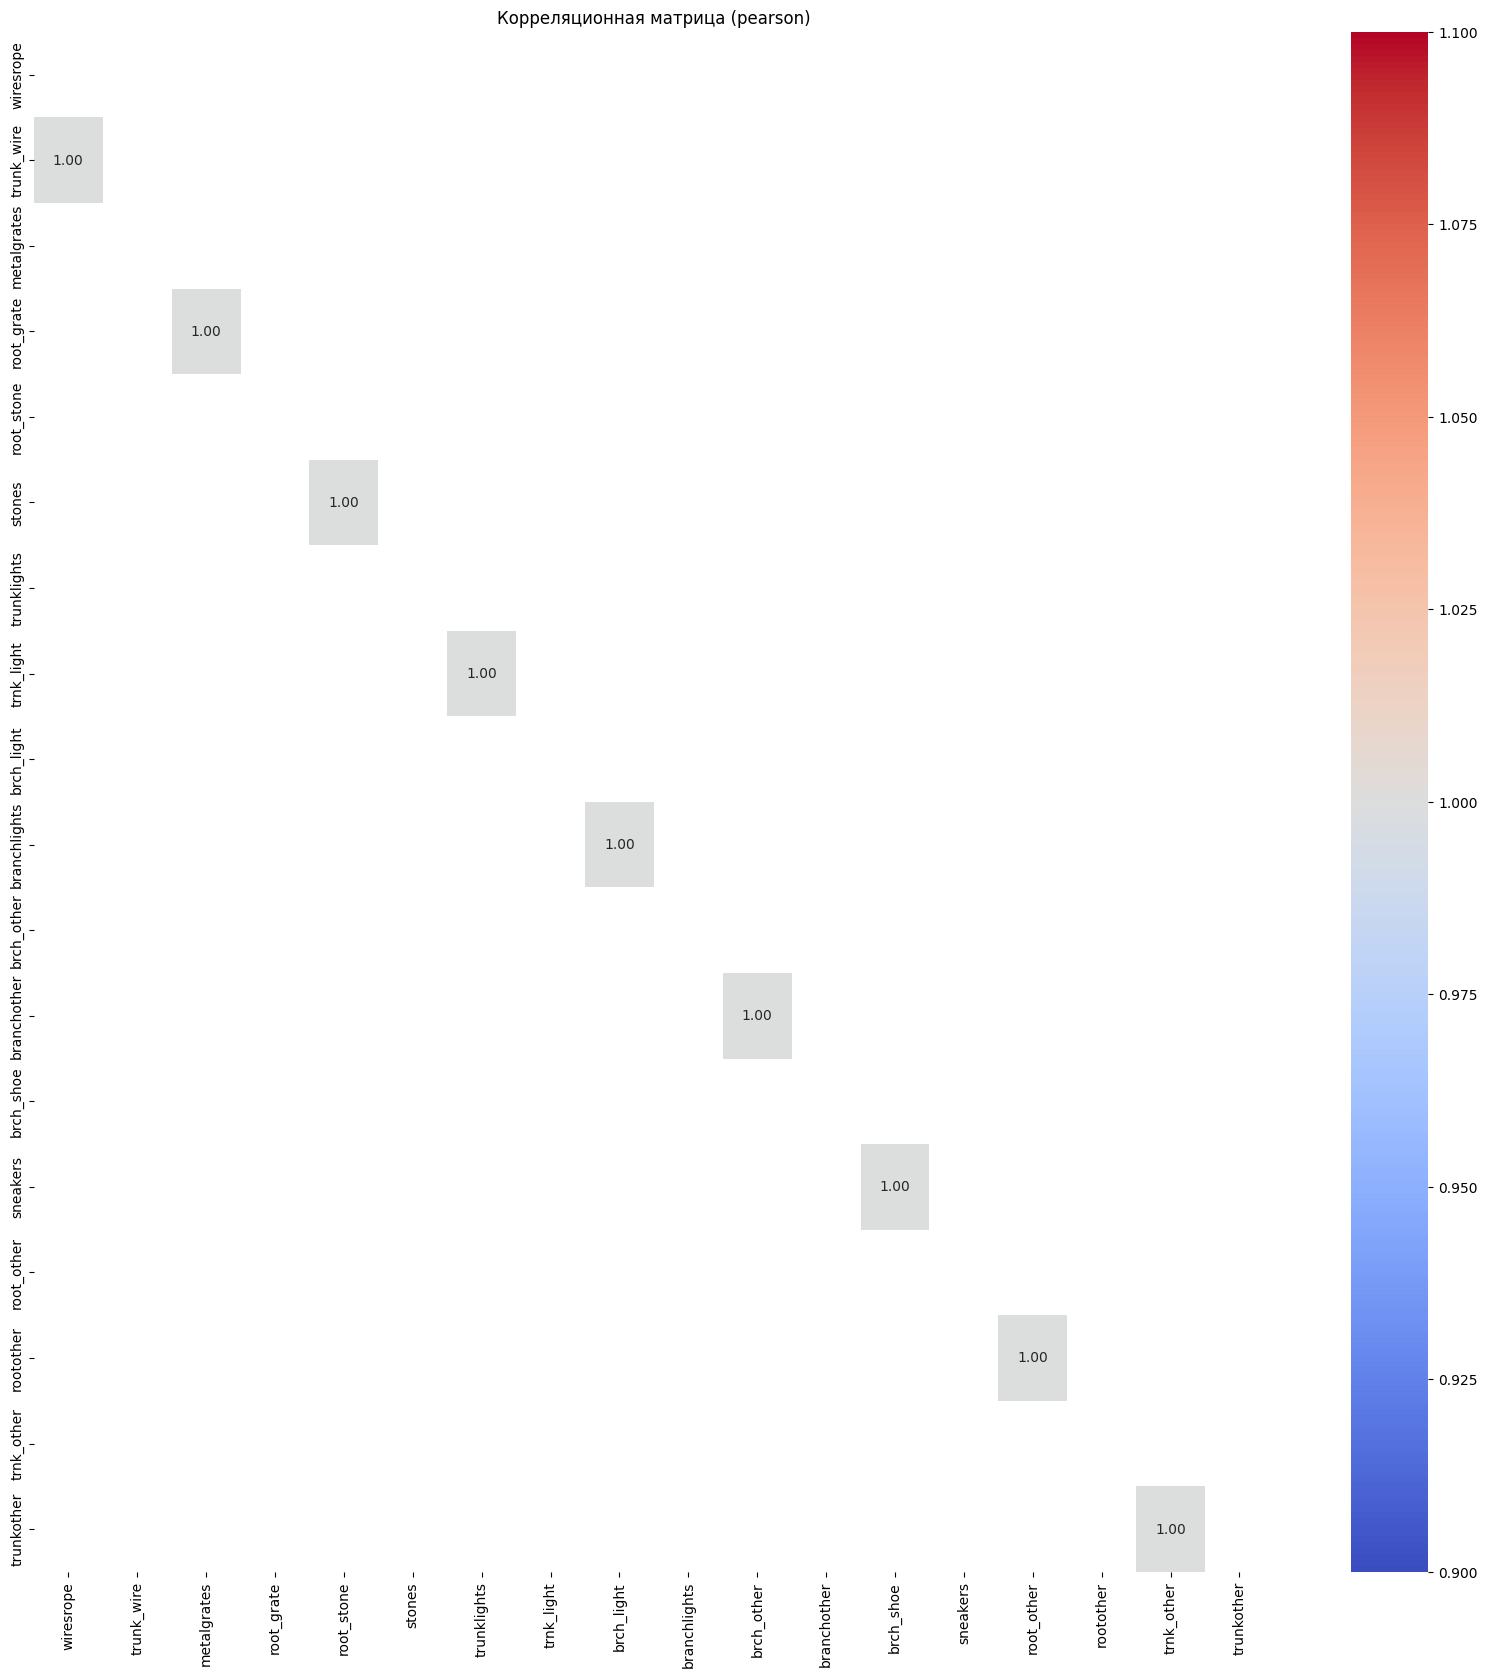

In [25]:
plot_corr_matrix(
    df[new_columns
    ],
    method="pearson",
)

Колонки из поля проблем повторяются и уже есть в датасете поэтому исключаем коррелирующиепризнаки

In [28]:
drop_columns = ['trunklights', 'metalgrates', 'branchother', 'sneakers', 'wiresrope', 
    'branchlights', 'noproblem', 'rootother', 'stones', 'trunkother']

In [29]:
df = df.drop(columns=drop_columns)
df.shape

(652172, 28)

In [30]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()
categorical_columns

['health', 'spc_latin', 'steward', 'guards', 'user_type', 'borough', 'nta']

In [31]:
def encode_categorical(df):
    """
    Преобразование категориальных признаков в числовые значения
    """
    label_encoders = {}
    for column in categorical_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column].astype(str))
        label_encoders[column] = le
    return df, label_encoders
df, label_encoders = encode_categorical(df) 
# Сохранение энкодеров
with open(f'../models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
label_encoders

{'health': LabelEncoder(),
 'spc_latin': LabelEncoder(),
 'steward': LabelEncoder(),
 'guards': LabelEncoder(),
 'user_type': LabelEncoder(),
 'borough': LabelEncoder(),
 'nta': LabelEncoder()}

In [32]:
# Вывод значений, закодированных энкодером для столбца 'health', вместе с соответствующими им числовыми кодами
health_classes = label_encoders['health'].classes_
health_codes = label_encoders['health'].transform(health_classes)

# Создание DataFrame для удобного отображения
health_mapping = pd.DataFrame({'Health': health_classes, 'Code': health_codes})
print(health_mapping)

  Health  Code
0   Fair     0
1   Good     1
2   Poor     2


## Расмотрим корреляцию

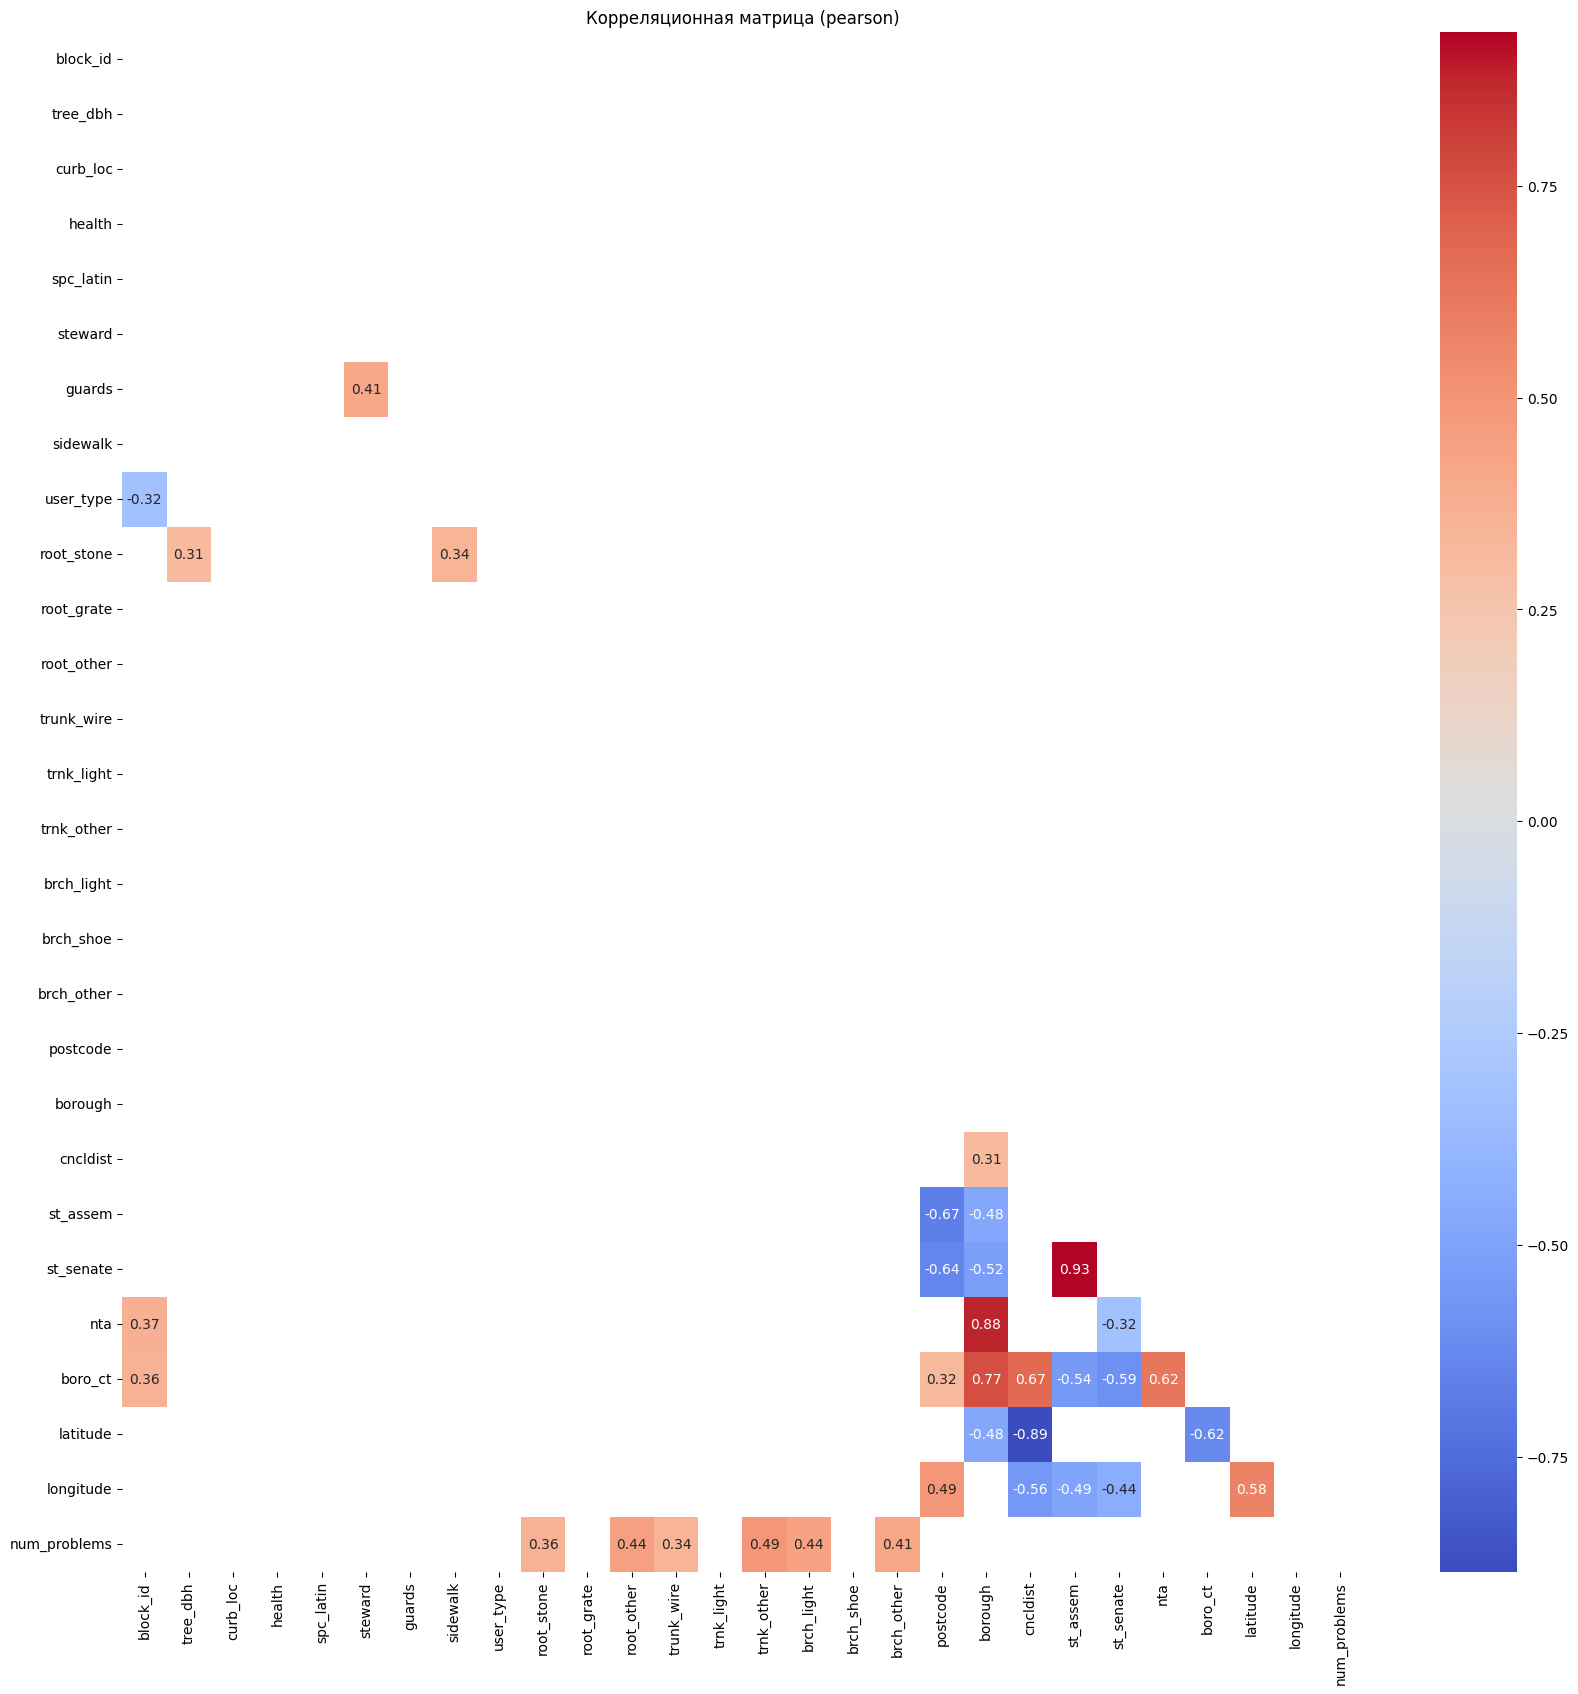

In [35]:
# Порог корреляции 0.3 
# у нас много категориальных признаков  и они не имеют линейной зависимости между собой 
# Вызов функции
plot_corr_matrix(df, method='pearson', threshold=0.3)